In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings(action= "ignore")

OBJECT OF THE STUDY

Predict a patient who will be readmitted in 30 days after having treatment in hospital and discharged


DATASET DESCRIPTION

In [35]:
df=pd.read_csv("./data_os/diabetic_data_readmission.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
# Data Cleaning

In [37]:
# NaN fields in the data "?" coded with "?" we make the data that is NaN. Then we will fix the missing value problem

df.replace("?",np.nan,inplace=True)


In [38]:
# The function finding the ratio of missing values

def missing_df(df):
    
    total_missing = df.isnull().sum().sort_values(ascending = False)
    pct_missing = total_missing/len(df)*100
    pct_missing = pct_missing.round(1)
    missing_df = pd.concat([total_missing, pct_missing], axis = 1, keys=["Total", "Pct"])
    #missing_df.columns = ["Total", "Pct"]
    return missing_df[missing_df.Total > 0]

In [40]:
missing_df(df)

,Total,Pct
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


In [41]:
df.shape

(101766, 50)

In [42]:
# We're dropping the features that have very much missing values
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)

# encounter_id,patient_nbr,admission_type_id will be dropped while feature with Id will not have significant effect on Analyse.
df.drop(['encounter_id','patient_nbr','admission_type_id',
         'discharge_disposition_id','admission_source_id'],axis=1,inplace=True)

#removing invalid/unknown entries for gender
df=df[df['gender']!='Unknown/Invalid']

# The remaining missing values, which are represented by a very small % and 
# understood that they cannot be filled with the interpolate method, are dropped.
df.dropna(inplace=True)

In [44]:
#We test whether there is Missing Value left
missing_df(df)

,Total,Pct


In [29]:
df.shape

(98052, 42)

In [45]:
#  Since we are dealing with early readmission our target class was into two category diveded. 
df["readmitted"].replace("NO", 0, inplace=True)
df["readmitted"].replace(">30", 0,inplace=True)
df["readmitted"].replace("<30",1, inplace=True)

In [46]:
# We detect numerical and objective features
numerical_features = df.dtypes[df.dtypes != 'object'].index
categorical_features = df.dtypes[df.dtypes == 'object'].index
categorical_features

Index(['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [16]:
# With barplot and countplot, we are looking at the relationship between readmitted and other features.
# sns.barplot(data=df,x="number_diagnoses", y="readmitted")
# sns.countplot(data=df,x="insulin", hue="readmitted")

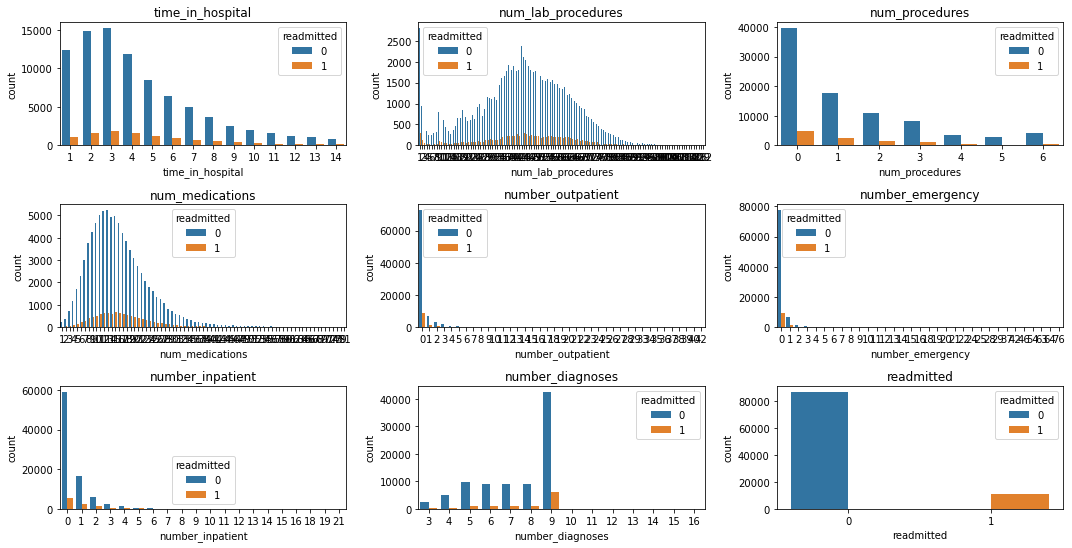

In [49]:
plt.figure(figsize=(15,30))
for i, col in enumerate(numerical_features[:]):
    plt.subplot(12,3,i+1)
    sns.countplot(data=df,x=numerical_features[i], hue="readmitted")
    plt.title(col)
#     plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

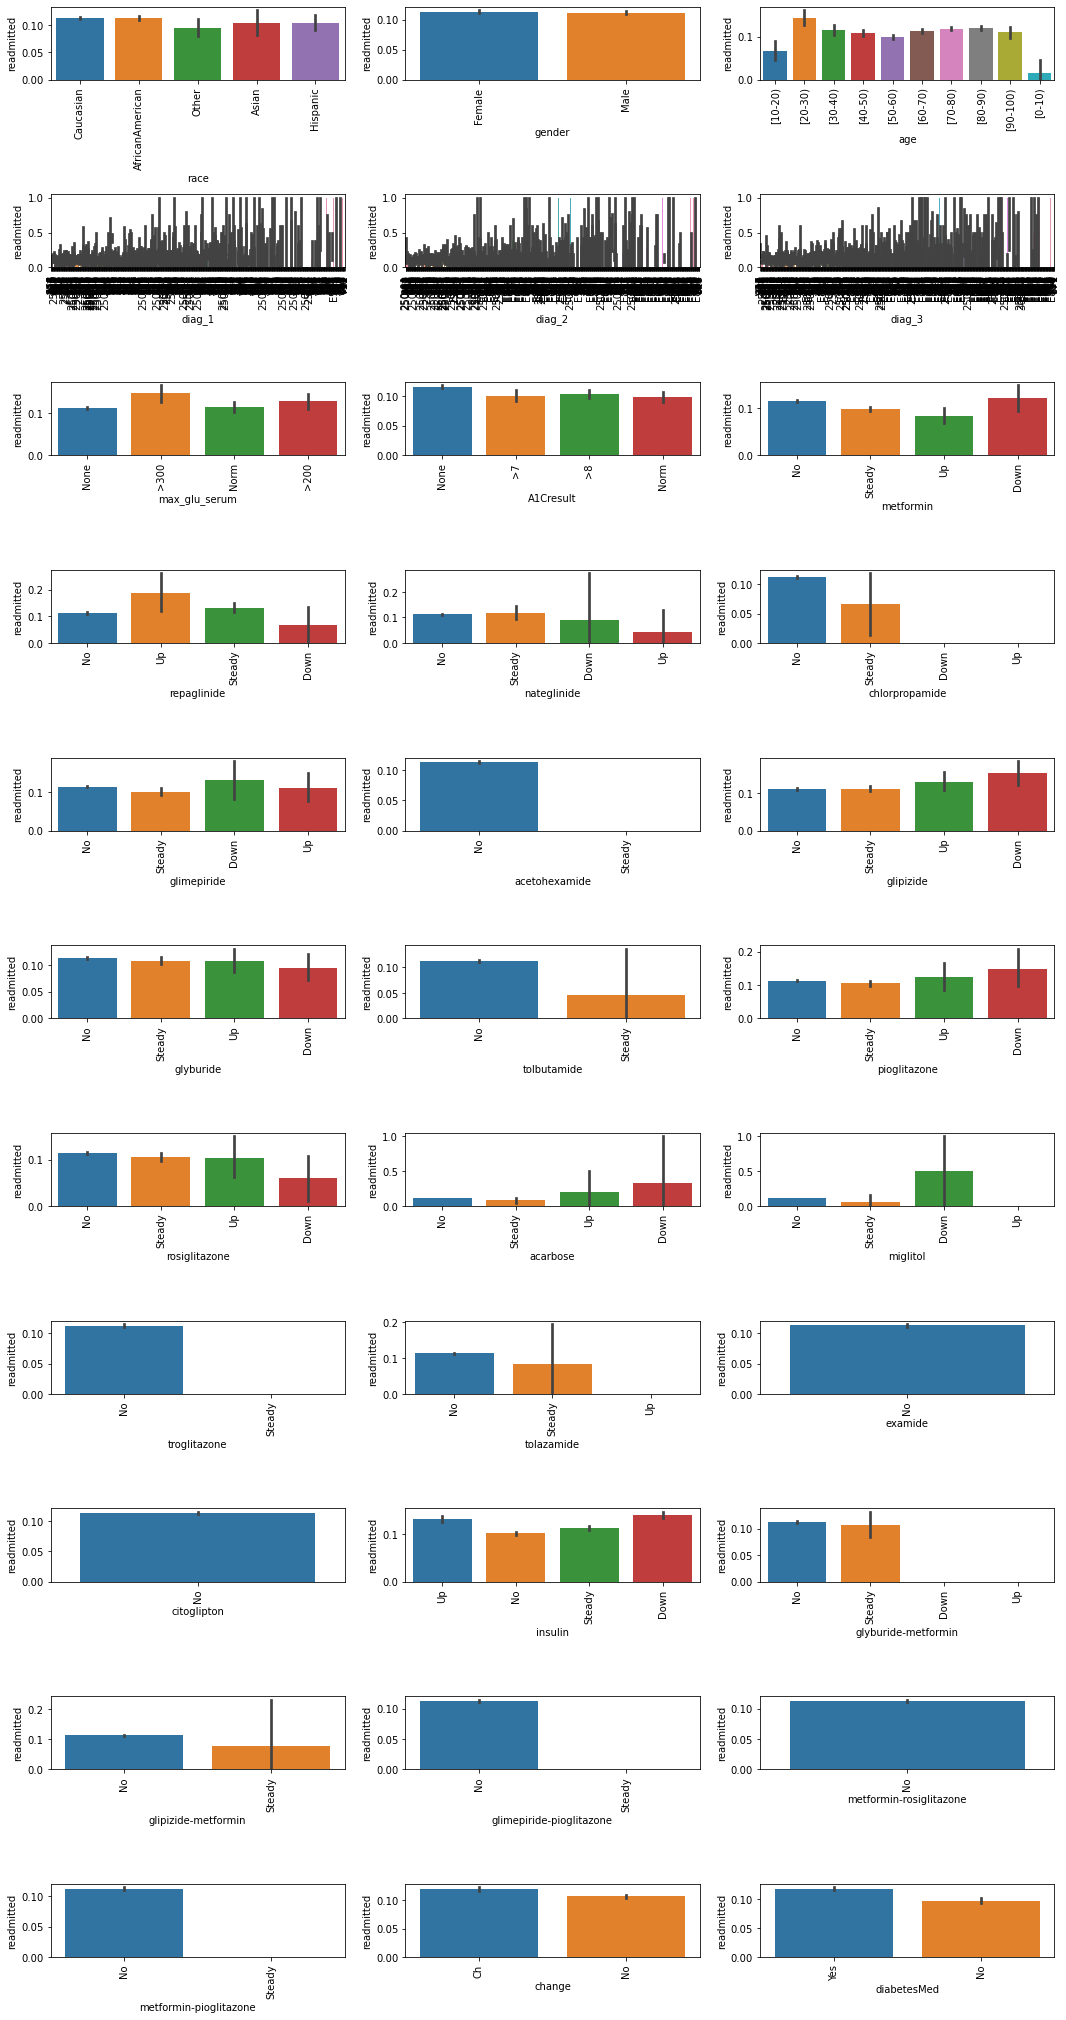

In [18]:
plt.figure(figsize=(15,30))
for i, col in enumerate(categorical_features[:]):
    plt.subplot(12,3,i+1)
    sns.barplot(data=df, x=categorical_features[i], y="readmitted")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [47]:
# medications featurelarından examide,citoglipton ve metformin-rosiglitazone all values are "No" so we drop them.

df.drop(["examide","citoglipton","metformin-rosiglitazone"],axis=1,inplace=True)

In [48]:
# medication change
df["change"] = df["change"].replace("No", 0)
df["change"] = df["change"].replace("Ch", 1)

df["gender"] = df["gender"].replace("Female", 0)
df["gender"] = df["gender"].replace("Male", 1)

df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)


In [49]:
# Age is in time interval lets do it integer

df["age"] = df["age"].replace("[0-10)",10)
df["age"] = df["age"].replace("[10-20)",20)
df["age"] = df["age"].replace("[20-30)",30)
df["age"] = df["age"].replace("[30-40)",40)
df["age"] = df["age"].replace("[40-50)",50)
df["age"] = df["age"].replace("[50-60)",60)
df["age"] = df["age"].replace("[60-70)",70)
df["age"] = df["age"].replace("[70-80)",80)
df["age"] = df["age"].replace("[80-90)",90)
df["age"] = df["age"].replace("[90-100)",100)


In [50]:
df["age"] = df["age"].astype(int)

In [51]:
df.shape

(98052, 39)

In [24]:
#The values of  diag_1, diag_2 and diag_3 consist of data classified according to international disease codes,
#where we convert the grouped data into general disease names based on the information in the data description.
# coded as first three digits of ICD9

In [52]:
# diag_1, diag_2 and diag_3 values are encoded as Diabetes 250.x.We need to clear the .x here.
# We also delete E and V encoded with the first character E and V in some ICD9 columns.

cols_d=["diag_1", "diag_2", "diag_3"]

for col in cols_d:
    df[col]=df[col].str.replace("E","-")
    df[col]=df[col].str.replace("V","-")
    df.loc[df[col].str.contains("250"),col]="250"
    
df[cols_d]=df[cols_d].astype(float)


In [53]:
# diagnosis grouping

for col in cols_d:
    df['temp']=np.nan
    
    condition = df[col]==250
    df.loc[condition,'temp']='Diabetes'
    
    condition = (df[col]>=390) & (df[col]<=458) | (df[col]==785)
    df.loc[condition,'temp']='Circulatory'
    
    condition = (df[col]>=460) & (df[col]<=519) | (df[col]==786)
    df.loc[condition,'temp']='Respiratory'
    
    condition = (df[col]>=520) & (df[col]<=579) | (df[col]==787)
    df.loc[condition,'temp']='Digestive'
    
    condition = (df[col]>=580) & (df[col]<=629) | (df[col]==788)
    df.loc[condition,'temp']='Genitourinary'
    
    condition = (df[col]>=800) & (df[col]<=999)
    df.loc[condition,'temp']='Injury'
    
    condition = (df[col]>=710) & (df[col]<=739)
    df.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df[col]>=140) & (df[col]<=239)
    df.loc[condition,'temp']='Neoplasms'
    
    condition = df[col]==0
    df.loc[condition,col]='?'
    df['temp']=df['temp'].fillna('Others')
    condition = df['temp']=='0'
    df.loc[condition,'temp']=np.nan
    df[col]=df['temp']
    df.drop('temp',axis=1,inplace=True)


In [54]:
df["readmitted"].value_counts()

0    86986
1    11066
Name: readmitted, dtype: int64

Patients readmitted in 30 days ratio %11.29
Patients nicht readmitted in 30 days ratio    : %88.71


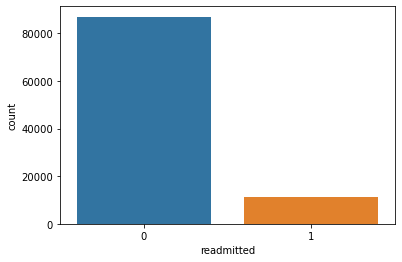

In [55]:
sns.countplot(df.readmitted)

print("Patients readmitted in 30 days ratio %{:.2f}".format(sum(df.readmitted)/len(df.readmitted)*100))
print("Patients nicht readmitted in 30 days ratio    : %{:.2f}".format((len(df.readmitted)-sum(df.readmitted))/len(df.readmitted)*100))

In [56]:
dfm=df.copy()

In [57]:
#We have the other features with dummies filled
dfm=pd.get_dummies(df)

In [58]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Columns: 120 entries, gender to metformin-pioglitazone_Steady
dtypes: int32(1), int64(12), uint8(107)
memory usage: 22.6 MB


In [60]:
dfm.shape

(98052, 120)

In [61]:
# Modelling

X=dfm.drop("readmitted", axis=1)
y=dfm["readmitted"]

In [62]:
# Split dataframe
    
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=111, stratify = y)

In [102]:
from sklearn.metrics import classification_report

In [103]:
# We set up our models with x and y datasets and receive classification reports.

def create_model(X, y):
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=111, stratify = y)
    
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)

    pred_train = logreg_model.predict(X_train)
    pred_test = logreg_model.predict(X_test)
    
    conf_mtx_train = confusion_matrix(y_train, pred_train)
    conf_mtx_test = confusion_matrix(y_test, pred_test)
    
    print("Accuracy : {}\n".format(logreg_model.score(X_test, y_test)))
       
     
    print("Train Dataset_smote")
    print(classification_report(y_train, pred_train))
    
    print("Test Dataset")
    print(classification_report(y_test, pred_test))
    
    return  None

In [104]:
create_model(X, y)

Accuracy : 0.8869512008566621

Train Dataset
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     69588
           1       0.49      0.02      0.03      8853

    accuracy                           0.89     78441
   macro avg       0.69      0.51      0.48     78441
weighted avg       0.84      0.89      0.84     78441

Test Dataset
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17398
           1       0.47      0.01      0.03      2213

    accuracy                           0.89     19611
   macro avg       0.68      0.51      0.48     19611
weighted avg       0.84      0.89      0.84     19611



In [ ]:
# Because it is imbalance data, we remodel it with SMOTE.

In [80]:
from imblearn.over_sampling import SMOTE

In [93]:
Xm=dfm.drop("readmitted", axis=1)
ym=dfm["readmitted"]


In [94]:

# Xm_train, Xm_test, ym_train, ym_test =  train_test_split(Xm, ym, test_size=0.20, random_state=25, stratify = ym)

In [116]:
smm = SMOTE(random_state=3, sampling_strategy=1.0)
X_smotem, y_smotem = smm.fit_resample(X_train, y_train)

In [117]:
print ("X_Smote shape", X_smotem.shape, ",Y_Smote shape", y_smotem.shape)

X_Smote shape (139176, 119) ,Y_Smote shape (139176,)


In [118]:
print ("X shape", X.shape, ",y shape", y.shape)

X shape (98052, 119) ,y shape (98052,)


In [119]:
print ("Xmtrain shape", X_train.shape, ",ymtrain shape", y_train.shape)

Xmtrain shape (78441, 119) ,ymtrain shape (78441,)


In [128]:
def create_model_smote(X_smotem, y_smotem, X_test, y_test):
    Xs_train, Xs_test, ys_train, ys_test =  train_test_split(X_smotem, y_smotem, test_size=0.20, random_state=111, stratify = y_smotem)
    
    logreg_models = LogisticRegression()
    logreg_models.fit(Xs_train, ys_train)

    pred_train_s = logreg_models.predict(Xs_train)
    pred_test_s = logreg_models.predict(Xs_test)
    pred_test = logreg_models.predict(X_test)
    
    conf_mtx_train_s = confusion_matrix(ys_train, pred_train_s)
    conf_mtx_test_s = confusion_matrix(ys_test, pred_test_s)
    conf_mtx_test = confusion_matrix(y_test, pred_test)
    
    print("Accuracy : {}\n".format(logreg_models.score(Xs_test, ys_test)))
    
    print("confusion Matrix-train_s")
    print(conf_mtx_train_s)
    
    print("confusion Matrix-test_s")
    print(conf_mtx_test_s)
    
    print("confusion Matrix-test")
    print(conf_mtx_test)
    
    print("Train Dataset_ Smote dataset")
    print(classification_report(ys_train, pred_train_s))
    
    print("Test Dataset_ Original Dataset")
    print(classification_report(y_test, pred_test))
    
    return  None

In [129]:
create_model_smote(X_smotem, y_smotem, X_test, y_test)

Accuracy : 0.9160798965368587

confusion Matrix-train_s
[[53728  1942]
 [ 7426 48244]]
confusion Matrix-test_s
[[13419   499]
 [ 1837 12081]]
confusion Matrix-test
[[16778   620]
 [ 2066   147]]
Train Dataset_ Smote dataset
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     55670
           1       0.96      0.87      0.91     55670

    accuracy                           0.92    111340
   macro avg       0.92      0.92      0.92    111340
weighted avg       0.92      0.92      0.92    111340

Test Dataset_ Original Dataset
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     17398
           1       0.19      0.07      0.10      2213

    accuracy                           0.86     19611
   macro avg       0.54      0.52      0.51     19611
weighted avg       0.81      0.86      0.83     19611



In [140]:
#If we set up the model directly with the smote X and y
create_model(X_smotem, y_smotem)

Accuracy : 0.9160798965368587

Train Dataset
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     55670
           1       0.96      0.87      0.91     55670

    accuracy                           0.92    111340
   macro avg       0.92      0.92      0.92    111340
weighted avg       0.92      0.92      0.92    111340

Test Dataset
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     13918
           1       0.96      0.87      0.91     13918

    accuracy                           0.92     27836
   macro avg       0.92      0.92      0.92     27836
weighted avg       0.92      0.92      0.92     27836



In [ ]:
# Polynomial feature
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# dfp=dfm.copy()
# Xpol=X_smote
# poly = PolynomialFeatures(interaction_only=True)
# XP=poly.fit_transform(Xpol)
# create_model(XP, y_smote)

In [ ]:
# Polynomial Features creates new features by multiplying all the features together, but the result was unexpected as it consumed too much resources

In [ ]:
# We can make the best estimation with at least how many feautures in our model, we use RFE for this.
# recursive feature elimination (RFE)

In [141]:
from sklearn.feature_selection import RFE

In [143]:
logreg_model = LogisticRegression()
selector = RFE(logreg_model, n_features_to_select=25, step=2)
selector = selector.fit(X_smotem, y_smotem)


In [144]:
selected_features= X_smotem.columns[selector.support_]
Xselected_features=X_smotem[selected_features]

In [145]:
create_model(Xselected_features,y_smotem)

Accuracy : 0.9167624658715333

Train Dataset
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     55670
           1       0.98      0.84      0.91     55670

    accuracy                           0.92    111340
   macro avg       0.92      0.92      0.91    111340
weighted avg       0.92      0.92      0.91    111340

Test Dataset
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     13918
           1       0.98      0.85      0.91     13918

    accuracy                           0.92     27836
   macro avg       0.93      0.92      0.92     27836
weighted avg       0.93      0.92      0.92     27836



In [146]:
#We find best 25 features by selecting n_features_to_select=25
selected_features

Index(['diag_1_Digestive', 'diag_1_Muscoloskeletal', 'diag_1_Neoplasms',
       'diag_1_Respiratory', 'diag_2_Circulatory', 'diag_2_Diabetes',
       'diag_2_Digestive', 'diag_2_Genitourinary', 'diag_2_Injury',
       'diag_2_Muscoloskeletal', 'diag_2_Others', 'diag_2_Respiratory',
       'diag_3_Circulatory', 'diag_3_Diabetes', 'diag_3_Digestive',
       'diag_3_Genitourinary', 'diag_3_Injury', 'diag_3_Muscoloskeletal',
       'diag_3_Neoplasms', 'diag_3_Others', 'diag_3_Respiratory',
       'insulin_Down', 'insulin_No', 'insulin_Steady', 'insulin_Up'],
      dtype='object')

In [147]:
logreg_model = LogisticRegression()
selector = RFE(logreg_model, n_features_to_select=15, step=2)
selector = selector.fit(X_smotem, y_smotem)
selected_features= X_smotem.columns[selector.support_]
Xselected_features=X_smotem[selected_features]
create_model(Xselected_features,y_smotem)


Accuracy : 0.8862983187239546

Train Dataset
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     55670
           1       1.00      0.77      0.87     55670

    accuracy                           0.89    111340
   macro avg       0.91      0.89      0.88    111340
weighted avg       0.91      0.89      0.88    111340

Test Dataset
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     13918
           1       1.00      0.77      0.87     13918

    accuracy                           0.89     27836
   macro avg       0.91      0.89      0.88     27836
weighted avg       0.91      0.89      0.88     27836



In [148]:
#We find best 25 features by selecting n_features_to_select=25
selected_features

Index(['diag_2_Muscoloskeletal', 'diag_2_Respiratory', 'diag_3_Circulatory',
       'diag_3_Diabetes', 'diag_3_Digestive', 'diag_3_Genitourinary',
       'diag_3_Injury', 'diag_3_Muscoloskeletal', 'diag_3_Neoplasms',
       'diag_3_Others', 'diag_3_Respiratory', 'insulin_Down', 'insulin_No',
       'insulin_Steady', 'insulin_Up'],
      dtype='object')

In [149]:
#Modelling with Lojistik Regression with RFE selected 20 features

logreg_model = LogisticRegression()
selector = RFE(logreg_model, n_features_to_select=20, step=2)
selector = selector.fit(X_smotem, y_smotem)
selected_features= X_smotem.columns[selector.support_]
Xselected_features=X_smotem[selected_features]
create_model(Xselected_features,y_smotem)

Accuracy : 0.8862983187239546

Train Dataset
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     55670
           1       1.00      0.77      0.87     55670

    accuracy                           0.89    111340
   macro avg       0.91      0.89      0.88    111340
weighted avg       0.91      0.89      0.88    111340

Test Dataset
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     13918
           1       1.00      0.77      0.87     13918

    accuracy                           0.89     27836
   macro avg       0.91      0.89      0.88     27836
weighted avg       0.91      0.89      0.88     27836



In [150]:
selected_features

Index(['diag_2_Diabetes', 'diag_2_Digestive', 'diag_2_Genitourinary',
       'diag_2_Injury', 'diag_2_Muscoloskeletal', 'diag_2_Others',
       'diag_2_Respiratory', 'diag_3_Circulatory', 'diag_3_Diabetes',
       'diag_3_Digestive', 'diag_3_Genitourinary', 'diag_3_Injury',
       'diag_3_Muscoloskeletal', 'diag_3_Neoplasms', 'diag_3_Others',
       'diag_3_Respiratory', 'insulin_Down', 'insulin_No', 'insulin_Steady',
       'insulin_Up'],
      dtype='object')

In [ ]:
# Modelling with KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# neighbors = KNeighborsClassifier(n_neighbors=1)
# X = diabetes[['Glucose', 'BloodPressure']]
# Y = diabetes.Outcome
# neighbors.fit(X,Y)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 1)
# knn.fit(X_train,y_train)
# knn.score(X_test, y_test)

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
 X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=111, stratify = y)

In [153]:
#modeling with KNN when n_neighbors selected 2
knn = KNeighborsClassifier(n_neighbors = 2)

In [154]:
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.8781806129213197

In [155]:
#modeling with KNN when n_neighbors selected 3
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.8650757228086278

In [64]:
#modeling with KNN when n_neighbors selected 1
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.811891285503034

In [157]:
#modeling with KNN when n_neighbors selected 4
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.8832797919534955

In [158]:
#modeling with KNN when n_neighbors selected 5
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.8786905308245373

In [ ]:
#from here we understand that when we select n_neigbors parameter 4 than it gives best score

..CONCLUSION..


I went to the best of my ability to clean up the data. I have tried to feature elimination and used RFE and  have determined that diagnos results are the best predictive features.  In our data, I have faced the imbalanced data and used the SMOTE method to eliminate the imbalance problem.I have modeled the data with logistics regression and K-Neigbours-Network (KNN). I have predicted any patient who will be readmitted in 30 days after having treatment in hospital and discharged. The test scores are compared and in our model logistik regression gave 0,92 and KNN gave 0,88 respectively. 